In [1]:
# Image simulator imports
import cryojax.simulator as cs
from cryojax.utils import rfftn, irfftn, make_frequencies
from cryojax.utils.fft import fftn, irfftn, ifftn


In [2]:
import jax.numpy as jnp
import jax

In [3]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
# Volume filename and metadata
filename = "../hackathon/emd-3683.mrc"
density = cs.VoxelGrid.from_file(filename, pad_scale=1.5)
pose = cs.EulerPose(view_phi=-20., view_theta=100., view_psi=20.)
ensemble = cs.Ensemble(density=density, pose=pose)

2024-01-10 21:05:32.736101: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
shape = (128,128)
pixel_size = 2  # Angstroms
manager = cs.ImageManager(shape=shape, pad_scale=1.5)
#scattering = cs.NufftProject(manager, pixel_size=pixel_size, eps=1e-5)
scattering = cs.FourierSliceExtract(manager, pixel_size=pixel_size)


In [6]:
# Initialize the instrument
df = 800
optics = cs.CTFOptics(defocus_u=df, defocus_v=df, amplitude_contrast=.07)
exposure = cs.UniformExposure(N=1.0, mu=0.0)
instrument_s = cs.Instrument(exposure=exposure)
instrument_o = cs.Instrument(exposure=exposure, optics=optics)


Text(0.5, 1.0, 'CTF at defocus=800 \n cs.CTFOptics(defocus_u=defocus, defocus_v=defocus, amplitude_contrast=.07).evaluate(...)')

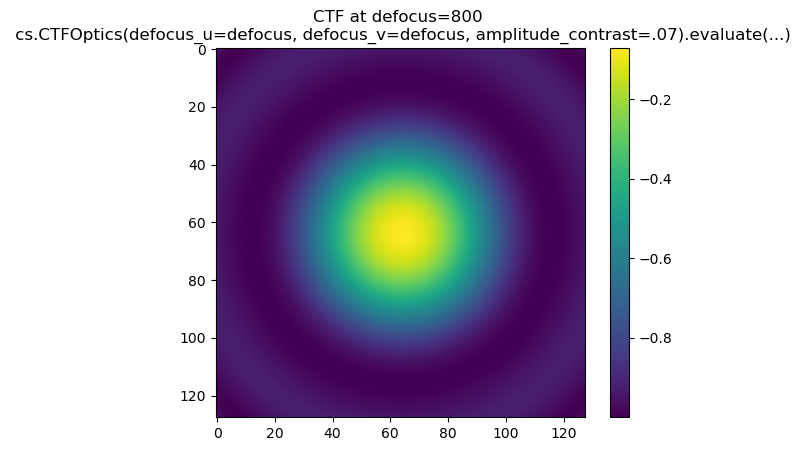

In [7]:
freqs = jnp.fft.fftshift(make_frequencies(shape, pixel_size, half_space=False))
ctf = optics.evaluate(freqs)
# ctf = jnp.ones_like(ctf)
plt.imshow(ctf)
plt.colorbar()
plt.title("CTF at defocus={} \n cs.CTFOptics(defocus_u=defocus, defocus_v=defocus, amplitude_contrast=.07).evaluate(...)".format(df))

Text(0.5, 1.0, 'cs.ImagePipeline(scattering=scattering, ensemble=ensemble).render()')

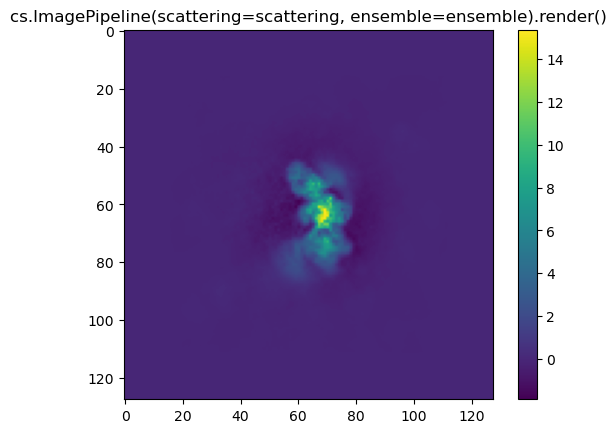

In [8]:
specimen_model = cs.ImagePipeline(scattering=scattering, ensemble=ensemble)

image_specimen = specimen_model.render()
plt.imshow(image_specimen)
plt.colorbar()
plt.title("cs.ImagePipeline(scattering=scattering, ensemble=ensemble).render()")


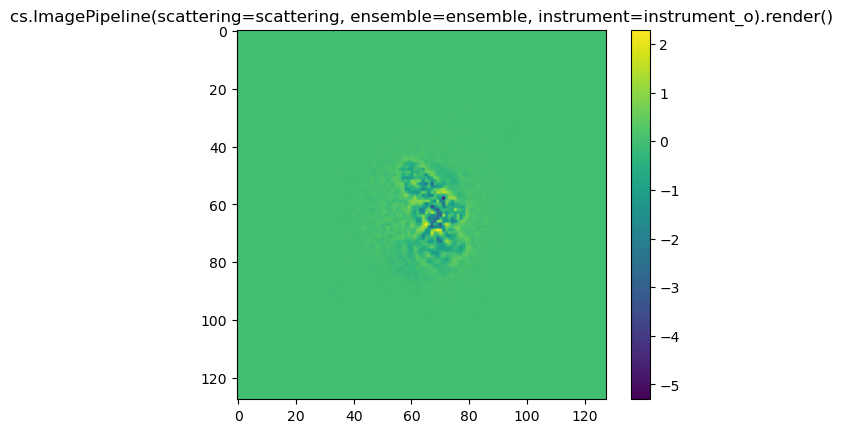

In [9]:
optics_model = cs.ImagePipeline(scattering=scattering, ensemble=ensemble, instrument=instrument_o)
image_ctf = optics_model.render()
plt.imshow(image_ctf)
plt.colorbar()
plt.title("cs.ImagePipeline(scattering=scattering, ensemble=ensemble, instrument=instrument_o).render()")

image_ctf_f = jnp.fft.fftshift(fftn(image_ctf))

In [10]:


# image_f = jnp.fft.fftshift(fftn(image_specimen))
# image_f_ctf = image_f * ctf
# image_ctf_r = ifftn(jnp.fft.ifftshift(image_f_ctf))
# plt.imshow(image_ctf_r.real)
# plt.colorbar()




In [11]:
def deconv_wiener_filter(image_ctf_f, ctf, eps):
    eps = 0.001
    wiener_filter = ctf / (ctf*ctf + eps)
    image_f_deconvolved = image_ctf_f * wiener_filter
    image_deconvolved = ifftn(jnp.fft.ifftshift(image_f_deconvolved))
    return image_deconvolved

image_deconvolved = deconv_wiener_filter(image_ctf_f, ctf, 0.001)
jnp.abs(image_deconvolved.real).sum(), jnp.abs(image_deconvolved.imag).sum()

(Array(3789.4736, dtype=float32), Array(0.00128174, dtype=float32))

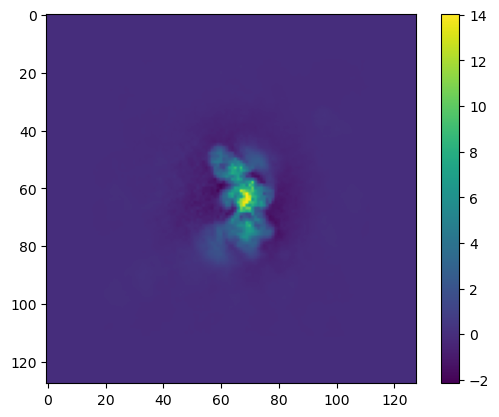

In [12]:
plt.imshow(image_deconvolved.real)
plt.colorbar()

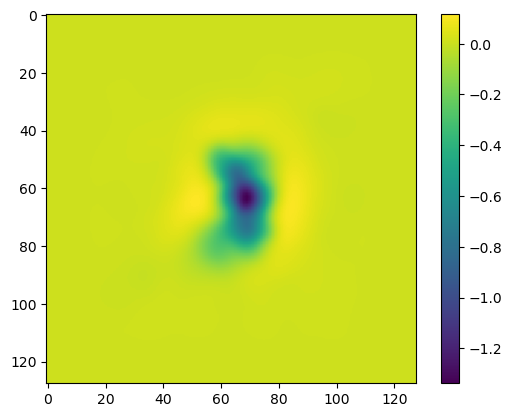

In [13]:
plt.imshow(image_deconvolved.real - image_specimen)
plt.colorbar()

# with noise

In [14]:
detector = cs.GaussianDetector(variance=cs.Constant(100.0))
instrument_d = cs.Instrument(exposure=exposure, optics=optics, detector=detector)
detetor_model = cs.ImagePipeline(scattering=scattering, ensemble=ensemble, instrument=instrument_d)

key = jax.random.PRNGKey(0)

image_ctf_noisy = detetor_model.sample(key)


Text(0.5, 1.0, 'cs.ImagePipeline(scattering=scattering, ensemble=ensemble, instrument=instrument_d).sample(...)')

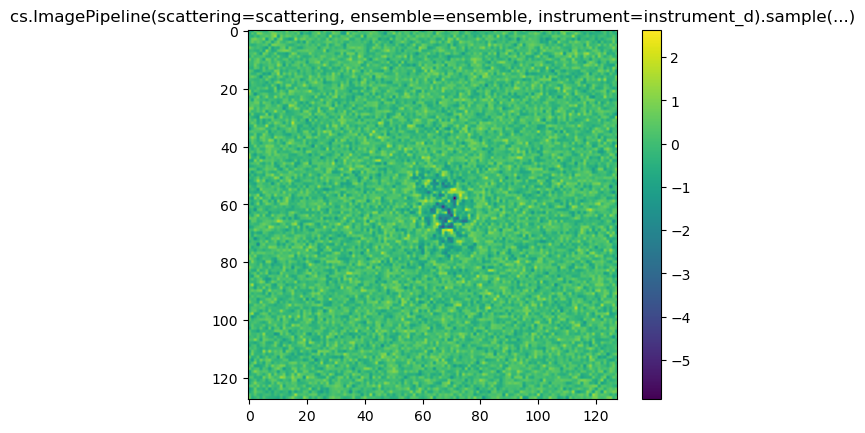

In [15]:
plt.imshow(image_ctf_noisy)
plt.colorbar()
plt.title('cs.ImagePipeline(scattering=scattering, ensemble=ensemble, instrument=instrument_d).sample(...)')

Text(0.5, 1.0, 'Deconvolved image')

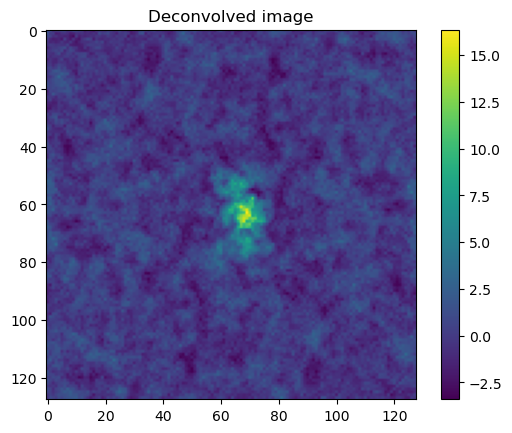

In [16]:
image_ctf_noisy_f = jnp.fft.fftshift(fftn(image_ctf_noisy))
image_deconvolved = deconv_wiener_filter(image_ctf_noisy_f, ctf, 0.05)
plt.imshow(image_deconvolved.real)
plt.colorbar()

plt.title('Deconvolved image')

# refactored in simulator.filter

In [17]:
from cryojax.simulator import WienerFilter

In [29]:
filter = WienerFilter(freqs, optics, 0.001)
image_deconvolved = ifftn(jnp.fft.ifftshift(filter(image_ctf_noisy_f)))


['__abstractclassvars__', '__abstractmethods__', '__abstractvars__', '__annotations__', '__call__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', 'amplitude_contrast', 'defocus_angle', 'defocus_u', 'defocus_v', 'degrees', 'envelope', 'evaluate', 'phase_shift', 'spherical_aberration', 'voltage']


(Array(15563.543, dtype=float32), Array(0.00296735, dtype=float32))

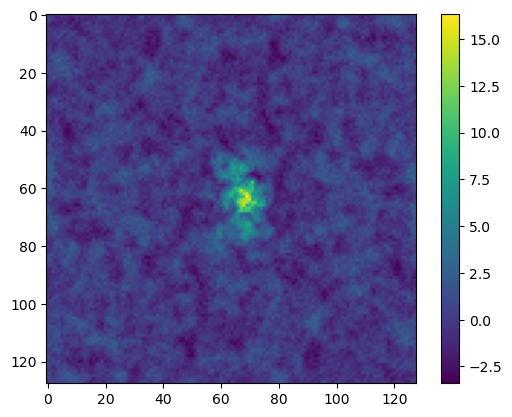

In [30]:
plt.imshow(image_deconvolved.real)
plt.colorbar()
jnp.abs(image_deconvolved.real).sum(), jnp.abs(image_deconvolved.imag).sum()